# Introduction to Neural Networks #

Neural Networks is the forefront of today's Machine Learning research. In this workshop, I will be going over how Neural Networks work and I will run over a hands-on example of using a Neural Network for Reinforcement Learning.

## Reinforcement Learning

Today we will be covering Q-learning, a specific type of learning that Google utilized back in 1900's.

### What is it used for?
* Playing Games (AI).
* Time series analysis (financial strategies).
* Robots (Manufacturing)
* Learning partially observable environments. Most problems you can apply POMDP to.



### How does it work?

Q-learning is a specific type of Reinforcement learning with the following setup.


---


Input: Observations from the environment

Output: Action to perform on the environment (optimal action-selection policy)

What it learns: Learns the expected reward of a performing an action on a given state. We call these expected values "policies".



---

This may seem confusing, let's work through our example first.


In this case, at every position that the cart is in, we feed the x and y coordinates to the Neural Network as input.

Then, Neural Network produces a value, which is the expected action to take on the environment given this x and y.

## Installing Dependencies

First off, let's import our libraries.

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import random

### Installing OpenAI's gym
Today, we will be using OpenAI's gym environment. To install on your computer, run 'pip install gym' on your command line (highly recommended!). You should also ensure you have OpenGL installed on your computer.

In [2]:
# Run this if you do not have opengl
!apt-get install python-opengl
# Run this to install OpenAI gym
!pip install gym
import gym

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Exploring the Environment

Great, now that we have installed gym, let's try to explore what it does. 

First, let's load the environment called 'MountainCarContinuous-v0' and call reset() to initialize our setup.

In [83]:
env = gym.make('CartPole-v1')
env.reset()
random.seed()

For every action on the environment, the environment provides us a list of fields, called observations that results from the action we took.

Let's take 5 actions and observe what we get back from the environment.

In [84]:
for step in range(5):
    action = env.action_space.sample()   # Generate a random action
    
    # Apply the predicted step onto the environment.
    # Receive back a observation, reward, done flag, and extra information
    obs1,reward,done,_ = env.step(action)
    
    print("STEP {}: We took an action {} and got back:".format(step,action))
    print("Observation {}".format(obs1))
    print("Reward: {} \n".format(reward))

STEP 0: We took an action 1 and got back:
Observation [-0.00127133  0.15222066 -0.03382395 -0.30086922]
Reward: 1.0 

STEP 1: We took an action 0 and got back:
Observation [ 0.00177308 -0.04240328 -0.03984134 -0.01904264]
Reward: 1.0 

STEP 2: We took an action 1 and got back:
Observation [ 0.00092502  0.15326672 -0.04022219 -0.32402498]
Reward: 1.0 

STEP 3: We took an action 1 and got back:
Observation [ 0.00399035  0.34893763 -0.04670269 -0.62911609]
Reward: 1.0 

STEP 4: We took an action 0 and got back:
Observation [ 0.0109691   0.15449747 -0.05928501 -0.35149947]
Reward: 1.0 



**Note**: *The input is an array of one element*

What does this mean? Well, for every action we've taken, we got back the parameters for the new state of the environment. We call these "Observations". Along with the observations, we are given a "Reward".


---


### Question: 
Why is Observation a matrix of dimension 4? What does each element in this matrix represent?


---


We will use the Observations as inputs to our Neural Network and we will use the Rewards for the loss function!

We can use the following commands to find the maximum Action values and maximum Observation values.

In [85]:
print(env.action_space)

print(env.observation_space.high)
print(env.observation_space.low)

Discrete(2)
[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


Great, now we know the bound of our action: {0, 1} and the expected values for our observation!

## Creating our Neural Network

Let's start to create our Neural Network. First, let's get some variables from the environment.

We can use this to determine how many input nodes we need and how many output nodes we need.

In [426]:
print(env.observation_space.shape)
INPUTSIZE = 4

print(env.action_space.shape)
OUTPUTSIZE = 2

# Size of hidden layers
HIDDENSIZE=10

(4,)
()


Tensorflow helps us build a graph of our Neural Network before we train the network. To start, let's reset the tensorflow graph.

In [427]:
tf.reset_default_graph()

### Input Layer:

Next, let's use the function `tf.placeholder(dtype, shape)` to create our input layer. Notice that the shape of the input layer is: 1 x 2 (or 1 x `INPUTSIZE`).

In [428]:
inputs = tf.placeholder(tf.float32, shape=(1,INPUTSIZE))

### Hidden Layers:

Now let's create the weights and bias to connect the input and the first hiddlen layer. Let's first declare our variables.

In [429]:
W1 = tf.get_variable("W1", shape=[INPUTSIZE, HIDDENSIZE], initializer=tf.contrib.layers.xavier_initializer())   # A 2 x 10 layer
b1 = tf.Variable(tf.zeros(HIDDENSIZE))   # Initialize bias with 0

Let's add both `W1` and `b1` together in a layer and call it `layer1`. 

`tf.matmul` multiplies inputs and W1 together. `tf.nn.relu` applies the Rectified Linear function to the equation.

In [430]:
layer1 = tf.nn.relu(tf.matmul(inputs, W1)+b1)   # Use ReLU activation function

Now let's do the same thing with the second layer. This time, the size of the layer is 10x10. In otherwords, `INPUTSIZE` x `INPUTSIZE`

In [431]:
W2 = tf.get_variable("W2", shape=[HIDDENSIZE, HIDDENSIZE], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.zeros(HIDDENSIZE))
layer2 = tf.nn.relu(tf.matmul(layer1, W2) + b2)

W3 = tf.get_variable("W3", shape=[HIDDENSIZE, HIDDENSIZE], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.zeros(HIDDENSIZE))
layer3 = tf.nn.relu(tf.matmul(layer2,W3)+b3)

### Output Layer:

Now it's time to create our output layer of size 10 x 1.

In [432]:
W4 = tf.get_variable("W4", shape=[HIDDENSIZE, OUTPUTSIZE], initializer=tf.contrib.layers.xavier_initializer())
layer_out= tf.matmul(layer3, W4)

The last layer, `layer_out` will produce a value, however, not neccessarily an action. We apply argmax, to get the index of action of the largest expected reward.

In [433]:
# Output: returns a value either 0 or 1
predict = tf.argmax(layer_out,1)

This prediction will be what we feed into the environment to get the next Observation!


---


After each action, we receive the reward from the environment. With the reward, we need to define a loss function to evaluate our Neural Network's performance.
Here we will use least squares for our loss function. There are other loss functions that we can use.

In [434]:
rewardQ = tf.placeholder(shape=[1,OUTPUTSIZE],dtype=tf.float32)
loss = tf.losses.mean_squared_error(rewardQ, layer_out)

Now, let's are declare our optimizer. A good choice in optimizer and learning rate can affect the time it takes to converge. Here we will use the Adam Optimizer, which is an optimizer extended from gradient descent. In practice, AdamOptimizer generally performs better than GradientDescentOptimizer. We also declare updateModel so we can have tensorflow minimize the loss function w.r.t. the optimizer.

In [541]:
trainer = tf.train.AdamOptimizer(learning_rate=0.01)
updateModel = trainer.minimize(loss)

Finally, let's declare a initializer. `init` will activate the initializers in all the variables.

In [542]:
# Initialize the weights and biases
init = tf.global_variables_initializer()

## Training the Network

Now, we can train our Neural Network.

First, let's set a few parameters for our Neural Network.

In [543]:
# Set learning parameters
gamma = 0.99
epsilon = 0.2
decay = 0.95
num_episodes = 500
maxsteps = 500

# For graphing rewards
rList=[]

We create a new Tensorflow session. These session instances keep track of things like Variables specific to the session.

In [544]:
sess = tf.Session()

As an example, let's use sess to call `init` and initialize our weights.

In [545]:
sess.run(init)

Great! Now all the weights are randomly assigned. Now, we can train our network.

In [546]:
obs=env.reset()
rAll, steps = 0, 0
done = False
while steps < maxsteps:
    # Run the network with obs, and received the values for predict and layer_out
    action, actionQs = sess.run([predict, layer_out], feed_dict={inputs:obs.reshape(1,INPUTSIZE)})

    # Epsilon greedy exploration
    if np.random.rand(1) < epsilon*(decay**steps):
        action[0] = env.action_space.sample()

    # Apply the predicted step onto the environment.
    # Receive back a observation, reward, done flag, and information
    next_obs,reward,done,_ = env.step(action[0])

    # Evaluate the neural network on next_obs: the observation after the action
    evalQ = sess.run(layer_out, feed_dict={inputs:next_obs.reshape(1,INPUTSIZE)})
    
    #Take the largest value of all the next Q(s',a') values
    max_evalQ = np.max(evalQ)
    # Grab the old Q function
    targetQ = actionQs
    
    # Update the (old) Q(s,a) value
    if done:
        targetQ[0,action[0]] = reward
    else:
        targetQ[0,action[0]] = reward + gamma*max_evalQ

    # This will train our network with the update Q(s,a) value
    # and update the weights once every episode.
    sess.run(updateModel, feed_dict={inputs:obs.reshape(1,INPUTSIZE),rewardQ:targetQ})
    # Change the state s=s'
    obs=next_obs

    # Add to the steps and record the reward for graphs
    steps += reward
    if done:
        rAll += steps
        rList.append(rAll)
        break;

Cool! Let's see how it did.

In [547]:
print("Episode: 1 Steps: "+str(steps))

Episode: 1 Steps: 12.0


More than likely, the neural network did not perform very well! Let's try to hit 500 steps by training it for 500 more iteraions.

In [548]:
for i in range(num_episodes):
    obs=env.reset()
    rAll, steps = 0, 0
    done = False
    while steps < maxsteps:
        #if i % 50 == 0:
            #env.render()
            
        action, actionQs = sess.run([predict, layer_out], feed_dict={inputs:obs.reshape(1,INPUTSIZE)})

        if np.random.rand(1) < epsilon:
            action[0] = env.action_space.sample()
            
        next_obs,reward,done,_ = env.step(action[0])

        evalQ = sess.run(layer_out, feed_dict={inputs:next_obs.reshape(1,INPUTSIZE)})
        max_evalQ = np.max(evalQ)
        targetQ = actionQs

        if done:
            targetQ[0,action[0]] = reward
        else:
            targetQ[0,action[0]] = reward + gamma*max_evalQ

        sess.run(updateModel, feed_dict={inputs:obs.reshape(1,INPUTSIZE),rewardQ:targetQ})
        obs=next_obs

        steps += reward
        if done:
            rAll += steps
            rList.append(rAll)
            break;
    print "Episode: {}/{} Steps: {}".format(i,num_episodes,rAll)

Episode: 0/500 Steps: 10.0
Episode: 1/500 Steps: 10.0
Episode: 2/500 Steps: 11.0
Episode: 3/500 Steps: 11.0
Episode: 4/500 Steps: 12.0
Episode: 5/500 Steps: 13.0
Episode: 6/500 Steps: 8.0
Episode: 7/500 Steps: 12.0
Episode: 8/500 Steps: 10.0
Episode: 9/500 Steps: 27.0
Episode: 10/500 Steps: 10.0
Episode: 11/500 Steps: 11.0
Episode: 12/500 Steps: 15.0
Episode: 13/500 Steps: 11.0
Episode: 14/500 Steps: 9.0
Episode: 15/500 Steps: 12.0
Episode: 16/500 Steps: 10.0
Episode: 17/500 Steps: 10.0
Episode: 18/500 Steps: 11.0
Episode: 19/500 Steps: 10.0
Episode: 20/500 Steps: 9.0
Episode: 21/500 Steps: 10.0
Episode: 22/500 Steps: 9.0
Episode: 23/500 Steps: 9.0
Episode: 24/500 Steps: 13.0
Episode: 25/500 Steps: 9.0
Episode: 26/500 Steps: 9.0
Episode: 27/500 Steps: 13.0
Episode: 28/500 Steps: 9.0
Episode: 29/500 Steps: 10.0
Episode: 30/500 Steps: 10.0
Episode: 31/500 Steps: 10.0
Episode: 32/500 Steps: 9.0
Episode: 33/500 Steps: 10.0
Episode: 34/500 Steps: 11.0
Episode: 35/500 Steps: 9.0
Episode: 36/

Episode: 288/500 Steps: 234.0
Episode: 289/500 Steps: 117.0
Episode: 290/500 Steps: 15.0
Episode: 291/500 Steps: 12.0
Episode: 292/500 Steps: 35.0
Episode: 293/500 Steps: 9.0
Episode: 294/500 Steps: 12.0
Episode: 295/500 Steps: 15.0
Episode: 296/500 Steps: 10.0
Episode: 297/500 Steps: 9.0
Episode: 298/500 Steps: 9.0
Episode: 299/500 Steps: 10.0
Episode: 300/500 Steps: 10.0
Episode: 301/500 Steps: 9.0
Episode: 302/500 Steps: 10.0
Episode: 303/500 Steps: 9.0
Episode: 304/500 Steps: 9.0
Episode: 305/500 Steps: 9.0
Episode: 306/500 Steps: 11.0
Episode: 307/500 Steps: 10.0
Episode: 308/500 Steps: 11.0
Episode: 309/500 Steps: 9.0
Episode: 310/500 Steps: 11.0
Episode: 311/500 Steps: 9.0
Episode: 312/500 Steps: 9.0
Episode: 313/500 Steps: 13.0
Episode: 314/500 Steps: 10.0
Episode: 315/500 Steps: 8.0
Episode: 316/500 Steps: 14.0
Episode: 317/500 Steps: 9.0
Episode: 318/500 Steps: 11.0
Episode: 319/500 Steps: 364.0
Episode: 320/500 Steps: 133.0
Episode: 321/500 Steps: 74.0
Episode: 322/500 Steps

Time to create a graph of how we did:

Average steps per episode: 37.664 steps


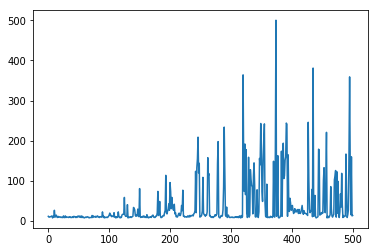

In [549]:
print "Average steps per episode: " + str(sum(rList)/num_episodes) + " steps"
plt.plot(rList)
plt.show()

Did it learn? Perhaps did the weights diverge? What happened?

Let's test it out on the environment

In [500]:
obs=env.reset()
steps = 0
done = False
while steps < maxsteps:
    #env.render()

    actions = sess.run(predict, feed_dict={inputs:obs.reshape(1,INPUTSIZE)})
    obs,reward,done,_ = env.step(actions[0])
    if done:
        print("Performed "+str(steps))
        break
    steps += reward

Performed 149.0


We are now done with the environment. Let's close the session.

In [368]:
sess.close()

Now you've created your (maybe first) neural network!

Where can we go from here?<br>
Keras for DQN: https://keon.io/deep-q-learning/ <br>
Convolutional Neural Networks: http://cs231n.github.io/convolutional-networks/ <br>
Long-Short Term Memory (LSTMs): http://colah.github.io/posts/2015-08-Understanding-LSTMs/ <br>
Deep Learning Specialization: https://www.coursera.org/specializations/deep-learning<br>
Loss functions in NNs: https://isaacchanghau.github.io/2017/06/07/Loss-Functions-in-Artificial-Neural-Networks/